In [1]:
### MACHINE LEARNING!!!
import numpy as np
import pandas as pd
import time
import gc

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [24]:
data_raw = pd.read_csv('final_tableau.csv')
data = data_raw[~(data_raw.isna().any(axis=1))]

In [25]:
fips = data.loc[:, "fips"]
data.drop(['fips', 'sales_per_capita', 'death_count', 'Unnamed: 0'], axis=1, inplace=True)

x_data = data.loc[:, data.columns != "deaths_per_100000"]
y_data = data.loc[:, "deaths_per_100000"]

/Users/bovice18/anaconda3/envs/team99/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
x_data.head()

,population,sales,median_income,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Percent of adults with less than a high school diploma, 2013-17","Percent of adults with a high school diploma only, 2013-17","Percent of adults completing some college or associate's degree, 2013-17","Percent of adults with a bachelor's degree or higher, 2013-17",PCTPOVALL_2017
1,52171.428571,3.038353e+06,50703.142857,2.0,2.0,12.3,33.6,29.1,25.0,13.4
2,179698.857143,9.989512e+06,48839.857143,3.0,2.0,9.8,27.8,31.7,30.7,10.1
3,28656.428571,1.141520e+06,30319.714286,6.0,6.0,26.9,35.5,25.5,12.0,33.4
4,22028.428571,1.059437e+06,37897.428571,1.0,1.0,17.9,43.9,25.0,13.2,20.2
5,57395.571429,1.705784e+06,43062.428571,1.0,1.0,20.2,32.3,34.4,13.1,12.8


In [27]:
random_state = 100
validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=validation_size, shuffle=True, random_state=random_state)

In [28]:
# Linear Regression
lr_learner = LinearRegression().fit(x_train, y_train)

y_pred = lr_learner.predict(x_train)
print(r2_score(y_train, y_pred))

0.28495867692557386


In [29]:
# Random Forest
rf_learner = RandomForestRegressor().fit(x_train, y_train)

y_pred = rf_learner.predict(x_train)
print(r2_score(y_train, y_pred))
y_pred = rf_learner.predict(x_test)
print(r2_score(y_test, y_pred))

0.9221211804741791
0.619487339805282


/Users/bovice18/anaconda3/envs/team99/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
# Neural Network

# first normalize data
scaler = StandardScaler()  
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)  
x_test_scaled = scaler.transform(x_test)

nn_learner = MLPRegressor().fit(x_train_scaled, y_train)

y_pred = nn_learner.predict(x_train_scaled)
print(r2_score(y_train, y_pred))
y_pred = nn_learner.predict(x_test_scaled)
print(r2_score(y_test, y_pred))

0.6116807777160316
0.6546539545936308


/Users/bovice18/anaconda3/envs/team99/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [31]:
# Random Forests show the most promise - now do some hyperparameter tuning
tuned_params = {'n_estimators': [5,10,25,50,100]}
rf_tuned = GridSearchCV(RandomForestRegressor(), tuned_params, cv=5).fit(x_train, y_train)
print(rf_tuned.best_params_)

{'n_estimators': 100}


In [32]:
#Final Learner
learner = RandomForestRegressor(n_estimators=50).fit(x_train, y_train)

y_pred = learner.predict(x_train)
print(r2_score(y_train, y_pred))
y_pred = learner.predict(x_test)
print(r2_score(y_test, y_pred))

0.9435596944552372
0.646771328711961


In [10]:
# Now increase and reduce sales and get predicted deaths_per_100000
data_plus_20 = data.copy()
data_plus_20['sales'] = data_plus_20['sales'] + 0.2 * data_plus_20['sales']
x_data_plus_20 = data_plus_20.loc[:, data.columns != "deaths_per_100000"]

data_minus_20 = data.copy()
data_minus_20['sales'] = data_minus_20['sales'] - 0.2 * data_minus_20['sales']
x_data_minus_20 = data_minus_20.loc[:, data.columns != "deaths_per_100000"]

y_pred_plus_20 = learner.predict(x_data_plus_20)
y_pred_minus_20 = learner.predict(x_data_minus_20)

out_plus_20_array = np.concatenate([fips.values.reshape(len(fips), 1), y_pred_plus_20.reshape((len(y_pred_plus_20), 1))], axis=1)

out_plus_20 = pd.DataFrame(out_plus_20_array, columns=['fips', 'deaths_per_100000'])
out_plus_20['fips'] = out_plus_20['fips'].astype(int)

out_minus_20_array = np.concatenate([fips.values.reshape(len(fips), 1), y_pred_minus_20.reshape((len(y_pred_minus_20), 1))], axis=1)

out_minus_20 = pd.DataFrame(out_minus_20_array, columns=['fips', 'deaths_per_100000'])
out_minus_20['fips'] = out_minus_20['fips'].astype(int)

out_plus_20['fips'] = out_plus_20['fips'].apply(str)
out_plus_20['fips'] = out_plus_20['fips'].str.zfill(5)

out_minus_20['fips'] = out_minus_20['fips'].apply(str)
out_minus_20['fips'] = out_minus_20['fips'].str.zfill(5)

print(out_plus_20.head())
print(out_minus_20.head())

out_plus_20.to_csv('data/ml-model/tableau_plus_20.csv')
out_minus_20.to_csv('data/ml-model/tableau_minus_20.csv')

    fips deaths_per_100000
0  01001           14.2656
1  01003           16.0268
2  01005           15.7862
3  01007            2.3235
4  01009             11.18
    fips deaths_per_100000
0  01001           10.9755
1  01003           15.8428
2  01005                 0
3  01007                 0
4  01009           6.67099


In [11]:
# Now increase and reduce sales and get predicted deaths_per_100000
data_plus_50 = data.copy()
data_plus_50['sales'] = data_plus_50['sales'] + 0.5 * data_plus_50['sales']
x_data_plus_50 = data_plus_50.loc[:, data.columns != "deaths_per_100000"]

data_minus_50 = data.copy()
data_minus_50['sales'] = data_minus_50['sales'] - 0.5 * data_minus_50['sales']
x_data_minus_50 = data_minus_50.loc[:, data.columns != "deaths_per_100000"]

y_pred_plus_50 = learner.predict(x_data_plus_50)
y_pred_minus_50 = learner.predict(x_data_minus_50)

out_plus_50_array = np.concatenate([fips.values.reshape(len(fips), 1), y_pred_plus_50.reshape((len(y_pred_plus_50), 1))], axis=1)

out_plus_50 = pd.DataFrame(out_plus_50_array, columns=['fips', 'deaths_per_100000'])
out_plus_50['fips'] = out_plus_50['fips'].astype(int)

out_minus_50_array = np.concatenate([fips.values.reshape(len(fips), 1), y_pred_minus_50.reshape((len(y_pred_minus_50), 1))], axis=1)

out_minus_50 = pd.DataFrame(out_minus_50_array, columns=['fips', 'deaths_per_100000'])
out_minus_50['fips'] = out_minus_50['fips'].astype(int)

out_plus_50['fips'] = out_plus_50['fips'].apply(str)
out_plus_50['fips'] = out_plus_50['fips'].str.zfill(5)

out_minus_50['fips'] = out_minus_50['fips'].apply(str)
out_minus_50['fips'] = out_minus_50['fips'].str.zfill(5)

print(out_plus_50.head())
print(out_minus_50.head())

out_plus_50.to_csv('data/ml-model/tableau_plus_50.csv')
out_minus_50.to_csv('data/ml-model/tableau_minus_50.csv')

    fips deaths_per_100000
0  01001           20.1632
1  01003           16.2195
2  01005           15.4123
3  01007           2.05801
4  01009           12.1467
    fips deaths_per_100000
0  01001           3.50866
1  01003           13.4968
2  01005                 0
3  01007                 0
4  01009          0.397611


In [33]:
# FEATURE IMPORTANCE FROM LEARNER
for i in np.flip(np.argsort(learner.feature_importances_)):
    print("{} - {}".format(x_data.columns[i], learner.feature_importances_[i]))
    
joined = [(x_data.columns[i], learner.feature_importances_[i]) for i in np.flip(np.argsort(learner.feature_importances_))]

sales - 0.6039662229104958
Percent of adults with a bachelor's degree or higher, 2013-17 - 0.09089371373657724
median_income - 0.0686003785040622
PCTPOVALL_2017 - 0.05185231320607836
population - 0.04816453918413668
Percent of adults with a high school diploma only, 2013-17 - 0.03839149025579985
Percent of adults completing some college or associate's degree, 2013-17 - 0.03311697562083797
Percent of adults with less than a high school diploma, 2013-17 - 0.029441993328793777
2013 Rural-urban Continuum Code - 0.022792180279803943
2013 Urban Influence Code - 0.012780192973414236


In [36]:
col_dict = {'population': 'Population',
            'sales': 'Opioid Sales',
            'sales_per_capita':'Opiods Sales / Capita',
            'median_income': 'Median Income',
            '2013 Rural-urban Continuum Code': 'Rural Continuum Code', 
            '2013 Urban Influence Code': 'Urban Influence Code',
            'Percent of adults with less than a high school diploma, 2013-17': '% No HS Degree',
            'Percent of adults with a high school diploma only, 2013-17': '% Only HS Degree',
            "Percent of adults completing some college or associate's degree, 2013-17": '% Some college degree',
            "Percent of adults with a bachelor's degree or higher, 2013-17": '% Bachelor Degree',
            "PCTPOVALL_2017":'% Poverty'}
[col_dict.get(x, x) for x in x_data.columns]

['Population',
 'Opioid Sales',
 'Median Income',
 'Rural Continuum Code',
 'Urban Influence Code',
 '% No HS Degree',
 '% Only HS Degree',
 '% Some college degree',
 '% Bachelor Degree',
 '% Poverty']

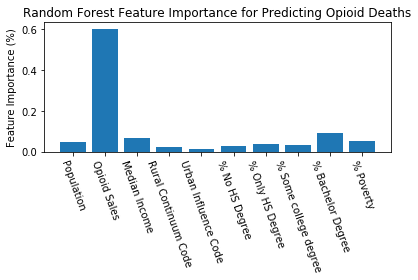

In [40]:
plt.bar([col_dict.get(x,x) for x in x_data.columns], learner.feature_importances_)
plt.xticks(rotation=-70)
plt.title("Random Forest Feature Importance for Predicting Opioid Deaths")
plt.ylabel("Feature Importance (%)")
plt.tight_layout()
plt.savefig('feature_importance.png')